# Proccessing auido files

In this notebook long audio files are cut into a set of short files and then convered into images on which the clasification task can be performed.

## Load libraries and install librosa if neccessary
[Librosa documentation](https://librosa.org/doc/latest/index.html)


In [ ]:
#!pip install librosa

In [ ]:
import librosa
import librosa.display

import IPython.display as ipd

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import os

Mount drive and change to relivant directory and list files saved in long_files folder

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd gdrive/MyDrive/Capstone_project/Phone_Rec_040522

/content/gdrive/MyDrive/Capstone_project/Phone_Rec_040522


In [ ]:
path_to_audio = './long_files/'

files = os.listdir(path_to_audio)

### Listen to an audio file

Long audio files can cause crash

In [ ]:
audio_data = files[4]

#ipd.Audio(path_to_audio+audio_data)

### Read an audio file into an numpy array and get the sample rate

In [ ]:
x, sr = librosa.load(path_to_audio+audio_data,sr=None)

In [ ]:
print('sample rate:',sr)
print('x is of type',type(x),'with shape',x.shape)
print('elements of x are of type',type(x[0]))
print('Audio file length',x.shape[0]//(sr*60),'min and',(x.shape[0]/sr)%60,'s')

sample rate: 32000
x is of type <class 'numpy.ndarray'> with shape (161363200,)
elements of x are of type <class 'numpy.float32'>
Audio file length 84 min and 2.600000000000364 s


## Helper function to chop long audio files into smaller clips and save these clips


In [ ]:
import soundfile as sf

def cutAudio(file_in, file_out, path_out, is_save=True, clip_length=5, shift = 0, sr=22050):
    """CutAudio is a function that splits a large audio file into clips of length
    clip_length. If is_save is True then clips are saved.

    Parameters
    -----------
    file_in:  string
      name of input audio file
    file_out: sting
      name of audio file of length clip_length
    path_out: string
      path where short audio files should be saved
    is_save:  bool    default = True
      choose whether or not to save short audio clips
    clip_length: float    default = 5
      length of short audio files in seconds
    shift:  float     default = 0
      shift the cutting window but a certain number of seconds
    sr: int   default = 22050
      sample rate
      
    Retrun
    ---------
    audio_filenames: list of strings
      list of the audio clip file names
    """

    # First load the file
    audio, sr = librosa.load(file_in,sr=sr)

    # Get number of samples for "clip_length" seconds
    buffer = clip_length * sr

    samples_total = len(audio)
    samples_wrote = 0 + int(abs(shift)*sr)
    counter = 1

    audio_filenames = []
    while samples_wrote < samples_total:
        #check if the buffer is not exceeding total samples 
        if buffer > (samples_total - samples_wrote):
            break
            

        block = audio[samples_wrote : (samples_wrote + buffer)]

        # Write 5 second segment
        out_filename =  path_out+str(counter) + "_" + file_out
        audio_filenames.append(out_filename)

        if is_save == True:
            sf.write(out_filename, block, sr)
          
        counter += 1
        samples_wrote += buffer
    return audio_filenames

## Iterate over all long audio files

Data is augmented by shifting by half the sample window

In [ ]:
sample_rate = 22050

In [ ]:
path_to_clips = "./splits/"

# If path_to_clips folder doesn't exist, then create it.
if not os.path.isdir(path_to_clips):
    os.makedirs(path_to_clips)

In [ ]:
for f in tqdm(files):
   audio_filenames_0 =  cutAudio(path_to_audio+f, 'shift_0_'+f,  path_to_clips, sr = sample_rate)
   audio_filenames_25 = cutAudio(path_to_audio+f, 'shift_25_'+f, path_to_clips, sr = sample_rate, shift = 2.5)

100%|██████████| 5/5 [05:58<00:00, 71.67s/it] 


## Take a look at a random audio clip

In [ ]:
files = os.listdir(path_to_clips)

(257, 227)


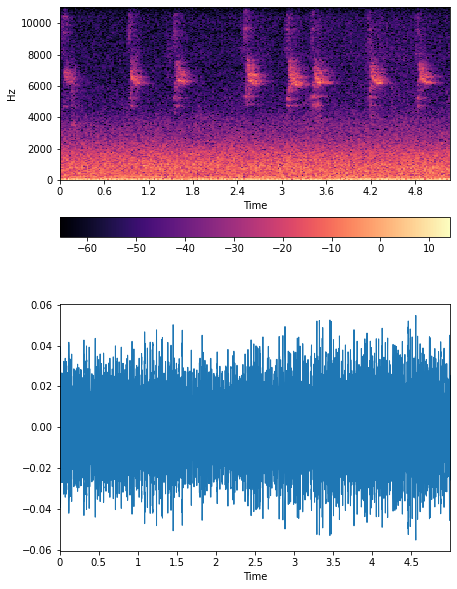

In [ ]:
f = path_to_clips+files[random.randint(0, len(files)-1)]

x, sr = librosa.load(f,sr=sample_rate)

X = librosa.stft(x,n_fft=2048//4, hop_length=128*4-26) #
Xdb = librosa.amplitude_to_db(abs(X))
print(Xdb.shape)

plt.figure(figsize=(7, 10))

plt.subplot(2,1,1)
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar(orientation = 'horizontal')

plt.subplot(2,1,2)
librosa.display.waveplot(x, sr=sample_rate)

plt.show()

ipd.Audio("./"+f)

## Create spectrograms 
Create images of the clips in the Fourier domain. These images will form the data set to be labeled.

In [ ]:
!ls

images	long_files  splits


In [ ]:
path_to_images = "./images/"

# If path_to_clips folder doesn't exist, then create it.
if not os.path.isdir(path_to_images):
    os.makedirs(path_to_images)


In [ ]:
for f in tqdm(files):
  x, sr = librosa.load(path_to_clips+f,sr=sample_rate)
  # Specifying n_ftt and hop_lenth will dictate the final image dimensions
  X = librosa.stft(x,n_fft=2048//4, hop_length=128*4-26)
  Xdb = librosa.amplitude_to_db(abs(X))

  # Ignore some subset of frequencies (optional depending on the task)
  Xdb = Xdb[30:,:]

  f_img = f.split('.')
  f_img = path_to_images+f_img[0]+'.png'
  plt.imsave(f_img,Xdb)

print('\n shape of images:', Xdb.shape)

100%|██████████| 6801/6801 [04:48<00:00, 23.54it/s]

shape of images: (216, 216)
